In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
import tensorflow as tf

## Basic RNN

### Manual RNN setup

In [3]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, shape=[None, n_inputs])
X1 = tf.placeholder(tf.float32, shape=[None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1,Wx) + b)

init = tf.global_variables_initializer()

In [4]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict = {X0: X0_batch, X1: X1_batch})

In [5]:
print(Y0_val)

[[-0.06640061  0.9625767   0.6810579   0.7091854  -0.89821595]
 [ 0.99777555 -0.7197888  -0.99657613  0.96739244 -0.99989706]
 [ 0.99999785 -0.9989881  -0.99999887  0.9967763  -0.9999999 ]
 [ 1.         -1.         -1.         -0.9981892   0.9995087 ]]


In [6]:
print(Y1_val)

[[ 1.         -1.         -1.          0.40200272 -0.99999994]
 [-0.12210429  0.62805295  0.96718436 -0.9937122  -0.2583933 ]
 [ 0.99999815 -0.9999994  -0.99999744 -0.8594331  -0.99998796]
 [ 0.99928296 -0.9999981  -0.9999059   0.98579615 -0.9220575 ]]


## Using static_rnn()

In [7]:
n_inputs = 3
n_neurons = 5

reset_graph()

X0 = tf.placeholder(tf.float32, shape=[None, n_inputs])
X1 = tf.placeholder(tf.float32, shape=[None, n_inputs])

basic_cell  = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], 
                                               dtype=tf.float32)
Y0, Y1 = output_seqs

In [8]:
init = tf.global_variables_initializer()

In [9]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [10]:
print(Y0_val)

[[ 0.30741337 -0.32884312 -0.6542847  -0.9385059   0.52089024]
 [ 0.9912275  -0.95425415 -0.7518078  -0.9995208   0.98202336]
 [ 0.99992675 -0.99783254 -0.82473516 -0.99999636  0.99947786]
 [ 0.9967709  -0.6875061   0.8419969   0.93039113  0.81206834]]


In [11]:
print(Y1_val)

[[ 0.99998885 -0.9997606  -0.06679297 -0.9999803   0.99982214]
 [-0.65249425 -0.5152086  -0.37968948 -0.5922594  -0.08968376]
 [ 0.998624   -0.99715203 -0.03308632 -0.9991566   0.9932902 ]
 [ 0.99681675 -0.9598194   0.39660627 -0.8307605   0.7967197 ]]


In [12]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add()
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow Graph"""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [13]:
show_graph(tf.get_default_graph())

## Packing sequences

reduce steps for setting up execution phase

In [14]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0 ,2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [15]:
init = tf.global_variables_initializer()

In [16]:
X_batch = np.array([
    # t = 0       t = 1
    [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [17]:
print(outputs_val)

[[[-0.4565232  -0.6806412   0.40938237  0.631045   -0.45732823]
  [-0.94288003 -0.9998869   0.9405581   0.99999845 -0.99999976]]

 [[-0.80015343 -0.99218273  0.78177965  0.9971032  -0.9964609 ]
  [-0.637116    0.11300934  0.5798437   0.43105593 -0.6371699 ]]

 [[-0.93605185 -0.99983793  0.9308867   0.9999814  -0.99998313]
  [-0.9165386  -0.99456036  0.89605415  0.9998719  -0.9999751 ]]

 [[ 0.99273676 -0.9981933  -0.5554365   0.99890316 -0.9953323 ]
  [-0.02746333 -0.7319198   0.7827872   0.9525682  -0.9781772 ]]]


## Using dynamic_rnn()

reduces memory capacity demand during backpropagation and allows swap_memory=True to allow the GPU to access CPU RAM

In [18]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [19]:
init = tf.global_variables_initializer()

In [20]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

## Setting the sequence lengths

In [21]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

In [22]:
seq_length = tf.placeholder(tf.int32, shape=[None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32, sequence_length=seq_length)

In [23]:
init = tf.global_variables_initializer()

In [24]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

seq_length_batch = np.array([2,1,2,2])

In [25]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states],
                                       feed_dict={X: X_batch, seq_length: seq_length_batch})

In [26]:
print(outputs_val)

[[[-0.91231877  0.16516447  0.5548655  -0.3915935   0.20846416]
  [-1.          0.95672596  0.9983169   0.9997017   0.96518576]]

 [[-0.99986124  0.67022896  0.9723652   0.66310453  0.74457586]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99999976  0.89679974  0.9986295   0.96475154  0.93662006]
  [-0.99995255  0.96819544  0.9600286   0.9870626   0.8545923 ]]

 [[-0.9643544   0.9950159  -0.361507    0.99833775  0.99949706]
  [-0.9613586   0.9568762   0.71322876  0.9772921  -0.09582992]]]


In [27]:
print(states_val)

[[-1.          0.95672596  0.9983169   0.9997017   0.96518576]
 [-0.99986124  0.67022896  0.9723652   0.66310453  0.74457586]
 [-0.99995255  0.96819544  0.9600286   0.9870626   0.8545923 ]
 [-0.9613586   0.9568762   0.71322876  0.9772921  -0.09582992]]


## Training a Sequence Classifier 



Note: the book uses tensorflow.contrib.layers.fully_connected() rather than tf.layers.dense() (which did not exist when this chapter was written). It is now preferable to use tf.layers.dense(), because anything in the contrib module may change or be deleted without notice. The dense() function is almost identical to the fully_connected() function. The main differences relevant to this chapter are:

    several parameters are renamed: scope becomes name, activation_fn becomes activation (and similarly the _fn suffix is removed from other parameters such as normalizer_fn), weights_initializer becomes kernel_initializer, etc.
    the default activation is now None rather than tf.nn.relu.



In [28]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [29]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [30]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy: ", acc_train, "Test accuracy:", acc_test)

0 Train accuracy:  0.93333334 Test accuracy: 0.9311
1 Train accuracy:  0.96666664 Test accuracy: 0.9522
2 Train accuracy:  0.97333336 Test accuracy: 0.9584
3 Train accuracy:  0.97333336 Test accuracy: 0.9665
4 Train accuracy:  0.96666664 Test accuracy: 0.9668
5 Train accuracy:  1.0 Test accuracy: 0.9675
6 Train accuracy:  0.98 Test accuracy: 0.9706
7 Train accuracy:  0.96666664 Test accuracy: 0.969
8 Train accuracy:  0.94 Test accuracy: 0.9603
9 Train accuracy:  0.9866667 Test accuracy: 0.9753
10 Train accuracy:  0.98 Test accuracy: 0.9763
11 Train accuracy:  0.97333336 Test accuracy: 0.9734
12 Train accuracy:  0.9866667 Test accuracy: 0.9743
13 Train accuracy:  0.9866667 Test accuracy: 0.9741
14 Train accuracy:  0.9866667 Test accuracy: 0.9751
15 Train accuracy:  0.99333334 Test accuracy: 0.972
16 Train accuracy:  0.99333334 Test accuracy: 0.976
17 Train accuracy:  0.9866667 Test accuracy: 0.9739
18 Train accuracy:  0.9866667 Test accuracy: 0.976
19 Train accuracy:  0.98 Test accuracy

In [31]:
reset_graph()

## Multi-layer RNN

In [32]:
reset_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

In [33]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
         for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [34]:
states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [35]:
n_epochs = 10
batch_size = 150 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "train accuracy:", acc_train, "Test Accuracy:", acc_test)

0 train accuracy: 0.9533333 Test Accuracy: 0.9352
1 train accuracy: 0.98 Test Accuracy: 0.9674
2 train accuracy: 0.96666664 Test Accuracy: 0.9684
3 train accuracy: 0.97333336 Test Accuracy: 0.968
4 train accuracy: 0.9866667 Test Accuracy: 0.9745
5 train accuracy: 0.97333336 Test Accuracy: 0.9736
6 train accuracy: 0.9866667 Test Accuracy: 0.9809
7 train accuracy: 1.0 Test Accuracy: 0.9788
8 train accuracy: 0.99333334 Test Accuracy: 0.9774
9 train accuracy: 0.97333336 Test Accuracy: 0.9778


## Time Series

In [36]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t* np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps *resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:,:-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

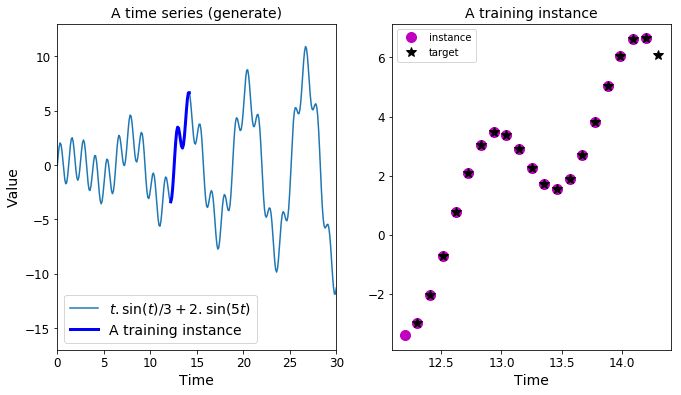

In [37]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps +1), n_steps +1)

plt.figure(figsize=(11,6))
plt.subplot(121)
plt.title("A time series (generate)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="best", fontsize=14)
plt.axis([0,30,-17,13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "mo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "k*", markersize=10, label="target")
plt.legend(loc="best")
plt.xlabel("Time")

plt.show()

In [38]:
X_batch, y_batch = next_batch(1, n_steps)

In [39]:
np.c_[X_batch[0], y_batch[0]]

array([[ 1.38452097,  2.05081182],
       [ 2.05081182,  2.29742291],
       [ 2.29742291,  2.0465599 ],
       [ 2.0465599 ,  1.34009916],
       [ 1.34009916,  0.32948704],
       [ 0.32948704, -0.76115235],
       [-0.76115235, -1.68967022],
       [-1.68967022, -2.25492776],
       [-2.25492776, -2.34576159],
       [-2.34576159, -1.96789418],
       [-1.96789418, -1.24220428],
       [-1.24220428, -0.37478448],
       [-0.37478448,  0.39387907],
       [ 0.39387907,  0.84815766],
       [ 0.84815766,  0.85045064],
       [ 0.85045064,  0.3752526 ],
       [ 0.3752526 , -0.48422846],
       [-0.48422846, -1.53852738],
       [-1.53852738, -2.54795941],
       [-2.54795941, -3.28097239]])

## Using an OutputProjectionWrapper

create the RNN. It will contain 100 recurrent neurons and we will unroll it over 20 time steps since each traiing instance will be 20 inputs long. Each input will contain only one feature (the value at that time). The targets are also sequences of 20 inputs, each containing a sigle value

In [40]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

At each time step we now have an output vector of size 100. But what we actually want is a single output value at each time step. The simplest solution is to wrap the cell in an OutputProjectionWrapper.

In [41]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_steps, n_outputs])

In [42]:
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,
                                                                         activation=tf.nn.relu),
                                             output_size=n_outputs)

In [43]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [44]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) #MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [45]:
saver = tf.train.Saver()

In [46]:
n_interations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_interations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
            
    saver.save(sess, "./my_time_series_model")

0 	MSE: 11.967253
100 	MSE: 0.5226269
200 	MSE: 0.15050448
300 	MSE: 0.07303933
400 	MSE: 0.062493816
500 	MSE: 0.060200285
600 	MSE: 0.05273162
700 	MSE: 0.048125897
800 	MSE: 0.050011408
900 	MSE: 0.047199152
1000 	MSE: 0.047066826
1100 	MSE: 0.048213676
1200 	MSE: 0.041079313
1300 	MSE: 0.04842212
1400 	MSE: 0.04208119


In [47]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [48]:
y_pred

array([[[-3.4052706],
        [-2.454452 ],
        [-1.1117992],
        [ 0.8052005],
        [ 2.1727405],
        [ 3.1086617],
        [ 3.431077 ],
        [ 3.3127377],
        [ 2.8998492],
        [ 2.2662616],
        [ 1.6512296],
        [ 1.5071106],
        [ 1.9100485],
        [ 2.729881 ],
        [ 3.9097762],
        [ 5.143193 ],
        [ 6.1320157],
        [ 6.649665 ],
        [ 6.6254163],
        [ 6.0586905]]], dtype=float32)

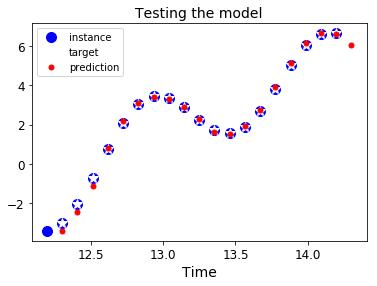

In [49]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## Without using an OutputProjectionWrapper


In [50]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_steps, n_outputs])

In [51]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [52]:
n_outputs = 1
learning_rate = 0.001

In [53]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [54]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [55]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
            
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")

0 	MSE: 13.907028
100 	MSE: 0.5059546
200 	MSE: 0.19918072
300 	MSE: 0.10306822
400 	MSE: 0.06800732
500 	MSE: 0.06320219
600 	MSE: 0.055968948
700 	MSE: 0.050048586
800 	MSE: 0.050842237
900 	MSE: 0.048475966
1000 	MSE: 0.04904387
1100 	MSE: 0.05132312
1200 	MSE: 0.04178274
1300 	MSE: 0.050539218
1400 	MSE: 0.043948453


In [56]:
y_pred

array([[[-3.4331954],
        [-2.468841 ],
        [-1.089337 ],
        [ 0.7290803],
        [ 2.169838 ],
        [ 3.1078804],
        [ 3.4581704],
        [ 3.333906 ],
        [ 2.838652 ],
        [ 2.2113476],
        [ 1.6919736],
        [ 1.5700686],
        [ 1.9109592],
        [ 2.759928 ],
        [ 3.9215653],
        [ 5.1424556],
        [ 6.1201563],
        [ 6.6646214],
        [ 6.639806 ],
        [ 6.064091 ]]], dtype=float32)

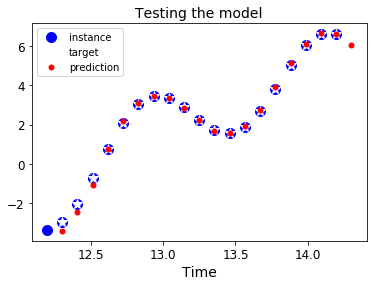

In [57]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## Generating a creative new sequence

In [58]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")
    
    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


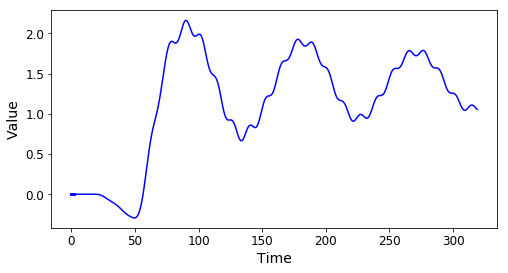

In [59]:


plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()



INFO:tensorflow:Restoring parameters from ./my_time_series_model


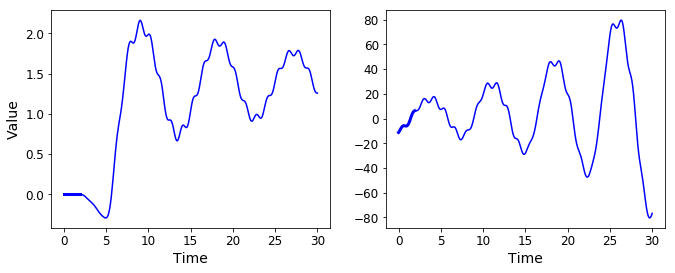

In [60]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.show()

## Deep RNN

### MultiRNNCell

In [61]:
reset_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])

In [62]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons) for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [63]:
init = tf.global_variables_initializer()

In [64]:
X_batch = np.random.rand(2, n_steps, n_inputs)

In [65]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [66]:
outputs_val.shape


(2, 5, 100)

## Dropout

In [67]:
reset_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

In [68]:
X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_steps, n_outputs])

In [69]:
keep_prob = tf.placeholder_with_default(1.0, shape=())
cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons) for layer in range(n_layers)]
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob) for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [70]:
learning_rate = 0.001

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [71]:
n_iterations = 1500
batch_size = 50
train_keep_prob = 0.5

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss], feed_dict={X:X_batch, y:y_batch, keep_prob:
                                                         train_keep_prob})
        if iteration % 100 == 0:
            print(iteration, "Training MSE:", mse)
            
    saver.save(sess, "./my_dropout_time_series_model")

0 Training MSE: 16.386942
100 Training MSE: 5.130103
200 Training MSE: 3.7831395
300 Training MSE: 3.5638201
400 Training MSE: 2.5496373
500 Training MSE: 3.580953
600 Training MSE: 2.947878
700 Training MSE: 3.1576571
800 Training MSE: 2.8287642
900 Training MSE: 2.9447
1000 Training MSE: 2.6170473
1100 Training MSE: 3.0912318
1200 Training MSE: 2.2802756
1300 Training MSE: 1.711484
1400 Training MSE: 2.4975126


In [72]:
with tf.Session() as sess:
    saver.restore(sess, "./my_dropout_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_dropout_time_series_model


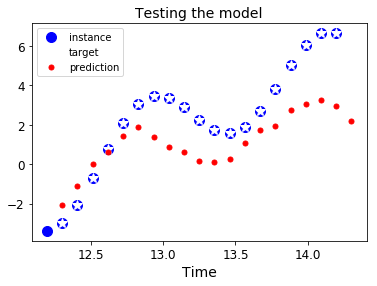

In [73]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## LSTM

Long Short Term Memory